Imports

In [84]:
"""Collection of general utility functions."""
import os
from typing import Tuple, Text, Dict, Union, Any

import numpy as np
from jax.experimental import sparse
from absl import logging
from jax import random, vmap, jit, grad, numpy as jnp
from jax.nn import softmax, relu
#from jax.ops import index_update, index DEPRECATED: replace with jax.numpy.ndarray.at in the corresponding code
from jax.scipy.linalg import expm
from scipy.optimize import minimize

Params = Tuple[jnp.ndarray, ...]
Results = Dict[Text, Union[jnp.ndarray, list, float]]
Tup = Tuple[float, float]



RESULT COLLECTION AND CHECKPOINTING

In [85]:
# =============================================================================
# RESULT COLLECTION AND CHECKPOINTING
# =============================================================================

def collect_results(params: Params) -> Results:
  """Create results dictionary from parameters at a given step.

  Args:
    params: The parameters to add to the results dictionary.

  Returns:
    results dictionary
  """
  results = {}
  weights, pos_spectrum, neg_spectrum, block_ul, block_ur = params
  results['weights'] = softmax(weights)
  spectra = make_spectra(pos_spectrum, neg_spectrum)
  results['spectra'] = spectra
  results['hamiltonian'] = make_hamiltonian(block_ul, block_ur)
  results['avg_neg_spec'] = jnp.mean(spectra[:, 1])
  results['avg_pos_spec'] = jnp.mean(spectra[:, 0])
  results['xs'] = make_xs(results['spectra'], results['hamiltonian'])
  return {k: np.array(v) for k, v in results.items()}


def write_checkpoint(params: Params,
                     name: Text,
                     out_dir: Text,
                     results: Dict = None) -> None:
  """Checkpoint current optimization parameters.

  Args:
    params: The current parameter tuple.
    name: The name under which to store the parameter checkpoint.
    out_dir: The directory where to store the parameters.
    results: If this result dictionary is not `None`, add the parameters (in
        their interpretable form) to the result dictionary and store this as
        in the same directory as `results.npz`.
  """
  result_path = os.path.join(out_dir, f"{name}.npz")
  weights, pos_spectrum, neg_spectrum, block_ul, block_ur = params
  np.savez(result_path, weights=weights, pos_spectrum=pos_spectrum,
           neg_spectrum=neg_spectrum, block_ul=block_ul, block_ur=block_ur)
  if results is not None:
    results.update(collect_results(params))
    result_path = os.path.join(out_dir, "results.npz")
    np.savez(result_path, **results)


Intialise

In [86]:
def init_params(key: jnp.ndarray, n: int, f: int, m: int,
                sigma_weights: float = 0, init_spectrum: float = 1,
                sigma_spectrum: float = 0) -> Params:
  """Initialize optimization parameters.
  Args:
    key: The random key.
    n: The spin dimension.
    f: The number of particles.
    m: The cardinality of the support of the discrete measure.
    sigma_weights: The standard deviation of the noise to be added to the fixed
      initialization of weights.
    init_spectrum: The initial absolute value of the mean of the negative
      eigenvalues. We will add 1/n to this value for each of the positive
      eigenvalues to ensure trace = 1.
    sigma_spectrum: The standard deviation of the noise to be added to the fixed
      initialization of the spectra.

  Returns:
    a 5-tuple of initial parameters:
        weights: The weights of the discrete measure (m,); real
        pos_spectrum: initial log values of pos spectrum (m, n); real
        neg_spectrum: initial log values of pos spectrum (m, n); real
        alphas: initial values of the alpha angles used to define the unitary (m,2n(f-n)-n): real
        betas: initial values of the beta angles used to define the unitary (m,2n(f-n)-n): real
  """
  subkeys = random.split(key, 5)
  weights = sigma_weights * random.normal(subkeys[0], (m,))
  # Initial pos spectra are all (init_spectrum + 1 / n) and
  # negative ones are all (init_spectrum)
  # We work with logs of desired spectra to ensure the correct signs later
  pos_spectrum = jnp.log(init_spectrum + 1. / n)
  pos_spectrum += sigma_spectrum * random.normal(subkeys[1], (m, n))
  neg_spectrum = jnp.log(init_spectrum)
  neg_spectrum += sigma_spectrum * random.normal(subkeys[2], (m, n))
  alphas = random.uniform(subkeys[3],(m,n*(2*f-2*n-1)), minval = 0, maxval = 4*jnp.pi)
  betas = random.uniform(subkeys[4],(m,n*(2*f-2*n-1)), minval = 0, maxval = jnp.pi/2)
  return weights, pos_spectrum, neg_spectrum, alphas, betas

Make spectra

In [87]:
def make_spectra(pos_spectrum: jnp.ndarray,
                 neg_spectrum: jnp.ndarray) -> jnp.ndarray:
  """Compute actual spectra from optimization parameters.

  The spectra have to have n positive and n negative eigenvalues
  and satisfy the trace constraint, which we ensure here.

  Args:
    pos_spectrum: Optimization parameters for positive eigenvalues.
    neg_spectrum: Optimization parameters for negative eigenvalues.

  Returns:
    Full (m, 2 n) array of the m spectra
  """
  spectra = jnp.concatenate((jnp.exp(pos_spectrum), - jnp.exp(neg_spectrum)), 1)
  return spectra / jnp.sum(spectra, axis=1)[..., jnp.newaxis]

Make the unitary matrix

In [88]:
def get_building_blocks(alphas:jnp.ndarray, betas:jnp.ndarray):
  """convert the arrays of angles into arrays of trigonometric functions which are "building blocks" of the band unitaries

  Args:
    alphas: Values of the alpha angles used to define the unitary (m,2n(f-n-1/2)): real
    betas: Values of the beta angles used to define the unitary (m,2n(f-n-1/2)): real
  Returns:
  3 "building blocks" terms, basic trigonometric functions of the alphas and betas of the same size
  (m,2n(f-n)-n)
  """
  exp_alphas = jnp.exp(1J*alphas)
  cos_betas = jnp.cos(betas)
  sin_betas = jnp.sin(betas)
  cos_betas_exp_pos_alphas = exp_alphas*cos_betas
  cos_betas_exp_neg_alphas = jnp.conj(exp_alphas)* cos_betas

  return cos_betas_exp_pos_alphas, cos_betas_exp_neg_alphas, sin_betas


In [89]:
#masks

def make_masks(f,n_col, band_number):

  """build

  Args:
    f: the number of particles
    n_col: the number of columns of the masks we want to build. To build a full matrix we will want n_col = f
    band_number: index of the band in the unitary decomposition (ranges from 1 to number of nonzero eigenvalues)
  Returns:
  3 arrays of masks of shape (f-band_number,f,n_col)
  """

  term_index = jnp.arange(f-band_number)[:,jnp.newaxis, jnp.newaxis]
  row_index = jnp.arange(f)[jnp.newaxis,:, jnp.newaxis]
  col_index = jnp.arange(n_col)[jnp.newaxis,jnp.newaxis,:]

  #conditions
  mask_cos_exp_pos = (row_index == term_index + band_number-1) & (band_number-1 <= col_index) & (col_index <= row_index)
  mask_cos_exp_neg = (col_index == term_index + band_number) & (row_index >= col_index)
  mask_sin = ((band_number-1 <= col_index) & (col_index <= term_index + band_number-1) & (row_index >= term_index + band_number)|
((row_index == term_index + band_number-1) & (col_index == row_index +1)))

  return mask_cos_exp_pos, mask_cos_exp_neg,mask_sin


In [90]:
def make_single_band_unitary(alphas_band,betas_band,f,n_col):
  """Use the angle parameters and the masks to generate a unitary band matrix

    Args:

    alphas_band: shape (f-band_number,)
    betas_band: shape (f-band_number,)
    f: dimension of the matrix (number of  particles)
    n_col: number of columns of the unitary which we want to build

  Returns:
    (f, n_col) band  unitary matrix
    """
  band_number = f - len(alphas_band)

  #extract the building blocks and masks
  building_blocks = get_building_blocks(alphas_band, betas_band)
  masks = make_masks(f,n_col,band_number)

  #initialise the band matrix with a matrix with ones on lower triangle and superdiagonal
  ones_tril= jnp.tril(jnp.ones((f,f))) + jnp.eye(f,k = 1)
  ones_tril = ones_tril[:,:n_col]
  band_matrix= ones_tril.copy()

  #iterate over the different masks for each building block
  num_masks = len(masks)
  for building_block_index in range(num_masks):
    mask = masks[building_block_index] #shape (f-band_number,f,f)
    building_block = building_blocks[building_block_index]
    band_matrix_building_block = mask*building_block[:,jnp.newaxis,jnp.newaxis]

    #add ones in the lower triangle and superdiagonal before multiplying  the matrices
    band_matrix_building_block += ones_tril - mask

    #multiply the matrices together
    band_matrix_building_block = jnp.prod(band_matrix_building_block, axis =0)

    #multiply the different  building blocks together
    band_matrix *=band_matrix_building_block

  #multiply by a final mask
  final_mask = jnp.tril(jnp.concatenate((jnp.zeros((f, band_number-1)), jnp.ones((f, f - band_number+1))), axis=1), k=-1)# zeros in first band_number-1  columns
  final_mask += jnp.eye(f) #add ones on the diagonal
  super_diagonal_terms = jnp.concatenate((jnp.zeros(band_number-1),jnp.ones(f-band_number)))
  final_mask -= jnp.diag(super_diagonal_terms, k = 1) #-1 on the superdiagonal to represent  the negative  sines
  band_matrix *= final_mask[:,:n_col] #shape (f,n_col)

  return band_matrix

  make_band_unitary = vmap(make_single_band_unitary, in_axes=(0, 0, None,None))

In [91]:
def make_single_eigenvectors(alphas,betas,f, n):
  """Use the angle parameters to build the 2n first eigenvectors of a spacetime point  x

    Args:
    f: dimension of the matrix (number of  particles)
    n: spin number hence  2n is total number of eigenvalues
    alphas: shape (2n(f-n)-n)
    betas: shape (2n(f-n)-n)

  Returns:
    (f,2n) matrix
    """
  #extract all the parameters
  num_alphas = len(alphas)
  building_blocks = get_building_blocks(alphas, betas)

  #initialise the eigenvectors:
  start_index = len(alphas)-(f-2*n)
  end_index = len(alphas)
  alphas_band, betas_band = alphas[start_index:end_index],betas[start_index:end_index]
  eigenvectors = make_single_band_unitary(alphas_band,betas_band,f,n_col = 2*n)

  #iterate over the remaining 2n-1 bands
  for band_number in range(2*n-1,0,-1):
    #extract the correct alphas and betas
    end_index = start_index
    start_index = end_index - (f - band_number)
    alphas_band, betas_band = alphas[start_index:end_index],betas[start_index:end_index]

    #build the band unitary
    band_matrix = make_single_band_unitary(alphas_band,betas_band,f,n_col = f)

    #multiply the unitaries and the vectors
    eigenvectors = jnp.dot(band_matrix,eigenvectors)

  return eigenvectors

  #vectorize
  make_eigenvectors = vmap(make_single_eigenvectors, in_axes=(0, 0, None,None))



Build Lagrangian


In [99]:
def make_lagrangian_1(spectra,eigenvectors, i: int, j: int) -> float:
  """The Lagrangian for a single pair of spacetime points for n = 1.

  Args:
    spectra: (m,2n)
    eigenvectors: (m,f,2n)
    i: Index for first point.
    j: Index for second point.

  Returns:
    value of the Lagrangian
  """
  gram = jnp.dot(jnp.conj(eigenvectors[i].T),eigenvectors[j])
  eigenvalue_products = jnp.outer(spectra[i],spectra[j])
  xy_product = jnp.dot(gram *eigenvalue_products, jnp.conj(gram.T)) #not exactly xy but an isospectral matrix, M in write up
  D = 0.5*(jnp.real(xy_product[0,0])-jnp.real(xy_product[1,1]))**2 + 2*jnp.real(xy_product[0,1]*xy_product[1,0])
  #R = jnp.trace(xy_product@xy_product) - 0.5*(jnp.trace(xy_product))**2
  return relu(D)

def make_lagrangian_n(spectra,eigenvectors, i: int, j: int) -> float:
  """The Lagrangian for a single pair of spacetime points for any n

  Args:
    spectra: (m,2n)
    eigenvectors: (m,f,2n)
    i: Index for first point.
    j: Index for second point.

  Returns:
    value of the Lagrangian
  """
  gram = jnp.dot(jnp.conj(eigenvectors[i].T),eigenvectors[j])
  two_n = gram.shape[0]
  eigenvalue_products = jnp.outer(spectra[i],spectra[j])
  xy_product = jnp.dot(gram *eigenvalue_products, jnp.conj(gram.T)) #not exactly xy but an isospectral matrix, M in write up

  spec = jnp.sort(jnp.abs(jnp.linalg.eigvals(xy_product)))
  bnd = jnp.sum(spec) ** 2

  return jnp.sum(spec ** 2) - bnd / (two_n)




test Make_lagrangian_1d

In [122]:
seed_value = 4
key = random.PRNGKey(seed_value)
f = 5
n = 1
m = 2

#initialise values

sigma_spectrum = 0.01
init_spectrum = 1
sigma_weights = 0.01

weights, pos_spectrum, neg_spectrum, alphas, betas = init_params(key,n,f,m,sigma_weights,init_spectrum,sigma_spectrum)


In [101]:
spectra = make_spectra(pos_spectrum,neg_spectrum)
make_eigenvectors = vmap(make_single_eigenvectors, in_axes=(0, 0, None,None))
eigenvectors = make_eigenvectors(alphas,betas,f,n)

print(make_lagrangian_1(spectra,eigenvectors,0,1))
print(make_lagrangian_n(spectra,eigenvectors,0,1))

0.0
0.0


Action

In [116]:
def action(params: Params) -> float:
  """The action.

  Args:
    params: The 5-tuple of parameters (weights, positive spectrum,
        negative spectrum, alphas, betas).

  Returns:
    single float for the value of the action
  """
  weights, pos_spectrum, neg_spectrum, alphas, betas = params
  weights = softmax(weights)
  spectra = make_spectra(pos_spectrum, neg_spectrum)
  m, n = pos_spectrum.shape

  make_eigenvectors = vmap(make_single_eigenvectors, in_axes=(0, 0, None,None))
  eigenvectors = make_eigenvectors(alphas, betas, f, n)

  # weighted sum of Lagrangian for pairs

  if n == 1:
    make_lag = vmap(make_lagrangian_1, (None, None, 0, 0))
  else:
    make_lag = vmap(make_lagrangian_n, (None, None, 0, 0))

  # Only looking at upper triangle (without diagonal)
  rows, cols = jnp.triu_indices(m, k=1)
  lag_ij = make_lag(spectra,eigenvectors, rows, cols)
  act = 2 * jnp.sum(weights[rows] * weights[cols] * lag_ij)
  # Add diagonal
  diag = jnp.arange(m)
  lag_ij = make_lag(spectra,eigenvectors, diag, diag)
  act += jnp.sum(weights ** 2 * lag_ij)
  return act

In [119]:
print(action([weights, pos_spectrum, neg_spectrum, alphas, betas]))

2.246978


Boundedness functional

In [105]:
# def boundedness_summand_1(spectra,eigenvectors, i: int, j: int) -> float:
#   """The summand involved in the computation of the boundary functinal, for a given single pair of spacetime points for n = 1.
#   Args:
#     spectra: (m,2n)
#     eigenvectors: (m,f,2n)
#     i: Index for first point.
#     j: Index for second point.

#   Returns:
#     value of the Lagrangian
#   """
#   gram = jnp.dot(jnp.conj(eigenvectors[i].T),eigenvectors[j])
#   eigenvalue_products = jnp.outer(spectra[i],spectra[j])
#   print(eigenvalue_products)
#   trace = jnp.sum(jnp.conj(gram)*gram*eigenvalue_products)
#   _bnd = jnp.real(trace**2)
#   return relu(_bnd)

def boundedness_summand(spectra,eigenvectors, i: int, j: int) -> float:
  """The summand involved in the computation of the boundary functinal, for a given single pair of spacetime points
  Args:
    spectra: (m,2n)
    eigenvectors: (m,f,2n)
    i: Index for first point.
    j: Index for second point.

  Returns:
    value of the summand
  """
  gram = jnp.dot(jnp.conj(eigenvectors[i].T),eigenvectors[j])
  eigenvalue_products = jnp.outer(spectra[i],spectra[j])
  xy_product = jnp.dot(gram *eigenvalue_products, jnp.conj(gram.T)) #not exactly xy but an isospectral matrix, M in write up
  spec = jnp.sort(jnp.abs(jnp.linalg.eigvals(xy_product)))
  _bnd = jnp.sum(spec) ** 2
  return _bnd



In [139]:
def boundedness(params: Params) -> float:
  """The boundedness functional.

  Args:
    params: The 5-tuple of parameters (weights, positive spectrum,
        negative spectrum, alphas, betas).

  Returns:
    single float for the value of the action
  """
  weights, pos_spectrum, neg_spectrum, alphas, betas = params
  weights = softmax(weights)
  spectra = make_spectra(pos_spectrum, neg_spectrum)
  m, n = pos_spectrum.shape

  make_eigenvectors = vmap(make_single_eigenvectors, in_axes=(0, 0, None,None))
  eigenvectors = make_eigenvectors(alphas, betas, f, n)

  make_bnd = vmap(boundedness_summand, (None, None, 0, 0))

  # Only looking at upper triangle (without diagonal)
  rows, cols = jnp.triu_indices(m, k=1)
  bnd_ij = make_bnd(spectra,eigenvectors, rows, cols)
  bnd = 2 * jnp.sum(weights[rows] * weights[cols] * bnd_ij)
  # Add diagonal
  diag = jnp.arange(m)
  bnd_ij = make_bnd(spectra,eigenvectors, diag, diag)
  bnd += jnp.sum(weights ** 2 * bnd_ij)
  return bnd


In [123]:
print(boundedness([weights, pos_spectrum, neg_spectrum, alphas, betas]))


13.918187


Optimisation

In [124]:
def _flatten_params(params: Params) -> jnp.ndarray:
  """Flatten all (complex) optimization parameters into single (real) vector."""
  all_params = []
  for p in params:
    if p.dtype in [jnp.float32, jnp.float64]:
      all_params.append(p.ravel())
    else:
      all_params.append(jnp.real(p.ravel()))
      all_params.append(jnp.imag(p.ravel()))
  return jnp.concatenate(all_params)


def _reconstruct_params(params: jnp.ndarray, n: int, f: int, m: int) -> Params:
  """Rearrange parameters into original shape from flat (real) vector.

  Returns:
    a 5-tuple of initial parameters:
        weights: The weights of the discrete measure (m,); real
        pos_spectrum: initial log values of pos spectrum (m, n); real
        neg_spectrum: initial log values of pos spectrum (m, n); real
        alphas: angle parameters for band unitaries (m, n(2f-2n-1)); real
        betas: angle parameters for band unitaries (m, n (2f-2n-1)); real
  """
  n_w = m
  n_pos = n_w + n * m
  n_neg = n_pos + n * m
  n_alphas = n_neg + m * (n*(2*f-2*n-1))
  splits = [n_w, n_pos, n_neg, n_alphas]
  (weights,
   pos_spectrum,
   neg_spectrum,
   alphas,
   betas) = jnp.split(params, splits)
  pos_spectrum = pos_spectrum.reshape(m, n)
  neg_spectrum = neg_spectrum.reshape(m, n)
  alphas = alphas.reshape(m,n*(2*f-2*n-1))
  betas = betas.reshape(m,n*(2*f-2*n-1))
  return weights, pos_spectrum, neg_spectrum, alphas, betas


def _action_flat_params(params: jnp.ndarray, n: int, f: int, m: int) -> float:
  """Action computation for bfgs optimization."""
  params = _reconstruct_params(params, n, f, m)
  return action(params)





Optimise simply

- initial parameters
- gradient descent function
- give optimised parameters and value of the action
- plot action as a function of m for n = 1, f = 2

In [136]:
#initialise parameters

sigma_weights = 0.01
sigma_spectrum = 0.01
lbfgs_maxiter = 10000
lbfgs_gtol = 1e-7
lbfgs_ftol = 1e-9
lbfgs_maxcor = 70
lbfgs_maxls = 20
bfgs_maxiter = 5000
bfgs_gtol = 1e-7
max_m_bfgs = 1000
seed = 543

key = random.PRNGKey(seed)

In [126]:
def n1_f2_neg_spectrum_from_m(m):
  """In the n=1, f=2 scenario, get the abs value of the neg eigenvalue at opt
  for 2-dim sphere.

  For the case n=1, f=2 *without* the boundedness constraint, the optimal
  solution is to send pos and neg eigenvalues to pos / neg infinity as m goes to
  infinity.
  We can compute these values for the positive and negative eigenvalues
  analytically.

  Returns:
    the absolute value of the negative eigenvalue at the optimum.
  """
  return (3 ** (1. / 4.) * jnp.sqrt(m / (2 * jnp.pi)) - 1.) / 4

optimise

In [145]:
def optimize(params: Params,
             n: int,
             f: int,
             m: int,
             lbfgs_options: Dict[Text, Any],
             bfgs_options: Dict[Text, Any],
             ) -> Tuple[Params, Results]:
  """Wrapper around the scipy BFGS minimizer that also collects results.

  Args:
    params: The tuple of optimization parameters.
    n: The desired spin dimension.
    f: The desired number of particles.
    m: The desired cardinality of the support of the discrete measure.
    lbfgs_options: The options to pass to L-BFGS. If the argument is None or the
        maxiter option is 0, don't run L-BFGS at all.
    bfgs_options: The options to pass to BFGS. If the argument is None or the
        maxiter option is 0, don't run BFGS at all.
  """

  if ((bfgs_options is None or bfgs_options['maxiter'] <= 0) and
      (lbfgs_options is None or lbfgs_options['maxiter'] <= 0)):
    raise ValueError("Run either bfgs or lbfgs for at least 1 iteration.")

  results = {
    'action': [],
    'boundedness': [],
    # 'n_iterations': [],
    'n': n,
    'f': f,
    'm': m
  }

  # ---------------------------------------------------------------------------
  # Initialization and setup
  # ---------------------------------------------------------------------------
  params0 = _flatten_params(params)

  # ---------------------------------------------------------------------------
  # L-BFGS (scipy)
  # ---------------------------------------------------------------------------
  f_act = jit(_action_flat_params, static_argnums=(1, 2, 3))
  func_grad = jit(grad(_action_flat_params), static_argnums=(1, 2, 3))
  g_act = lambda x, _n, _f, _m: np.array(func_grad(x, _n, _f, _m))
  res = None
  if lbfgs_options is not None and lbfgs_options['maxiter'] > 0:
    res = minimize(f_act, params0, args=(n, f, m), method="l-bfgs-b", jac=g_act, options=lbfgs_options)
    #results = _log_and_update_results("LBFGS", res, results)

  # ---------------------------------------------------------------------------
  # BFGS scipy
  # ---------------------------------------------------------------------------
  if bfgs_options is not None and bfgs_options['maxiter'] > 0:
    if res is not None:
      params0 = res.x
    res = minimize(f_act, params0, args=(n, f, m), method="bfgs", jac=g_act, options=bfgs_options)
  #results = _log_and_update_results("BFGS", res, results)

  # ---------------------------------------------------------------------------
  # Final results reporting
  # ---------------------------------------------------------------------------
  final_params = _reconstruct_params(res.x, n, f, m)
  act = action(final_params)
  #bnd = boundedness(final_params)
  results['action'].append(act)
  #results['boundedness'].append(bnd)
  return final_params, {k: np.array(v) for k, v in results.items()}


  #J'AI RETIRE LE CALLBACK!! PAREIL POUR BFGS y compris la référence dans les fonctions minimize, l'appell au callback, et tous les logs

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.166667
         Iterations: 1
         Function evaluations: 65
         Gradient evaluations: 54


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.166668
         Iterations: 0
         Function evaluations: 61
         Gradient evaluations: 49


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.168998
         Iterations: 4
         Function evaluations: 59
         Gradient evaluations: 47


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.147585
         Iterations: 4
         Function evaluations: 91
         Gradient evaluations: 78


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.145239
         Iterations: 5
         Function evaluations: 59
         Gradient evaluations: 47


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.143447
         Iterations: 64
         Function evaluations: 145
         Gradient evaluations: 134


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.144383
         Iterations: 4
         Function evaluations: 64
         Gradient evaluations: 52


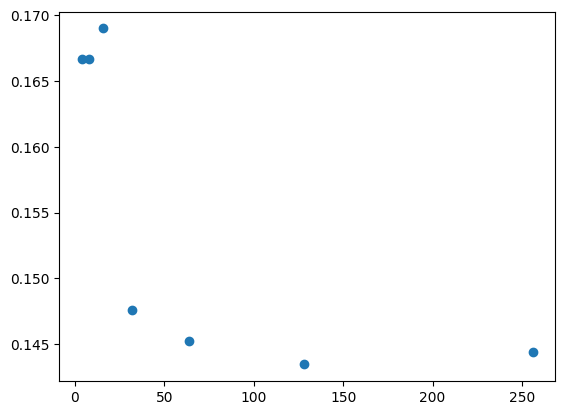

In [147]:
# ---------------------------------------------------------------------------
# Optimization and writing results
# ---------------------------------------------------------------------------
#n = 1, f = 2

import matplotlib.pyplot as plt

def main(n,f,m_sweep):

  # Parameter and result initialization
  # ---------------------------------------------------------------------------
  key2, subkey = random.split(key)

  # Setup (L)BFGS options
  # ---------------------------------------------------------------------------

  def make_options(m):
    lbfgs_options = {
      "maxiter": lbfgs_maxiter,
      "maxfun": 2 * lbfgs_maxiter,
      "disp": 50,
      "gtol": lbfgs_gtol,
      "ftol": lbfgs_ftol,
      "maxcor": lbfgs_maxcor,
      "maxls": lbfgs_maxls,
    }

    if max_m_bfgs < m:
      bfgs_options = None
    else:
      bfgs_options = {
        "maxiter": bfgs_maxiter,
        "disp": True,
        "gtol": bfgs_gtol,
      }
    return lbfgs_options,bfgs_options


  actions = []

  for m in m_sweep:
    lbfgs_options,bfgs_options = make_options(m)

    init_spectrum = 5*n1_f2_neg_spectrum_from_m(m)

    params_0 = init_params(subkey, n, f, m,
                            sigma_weights, init_spectrum,
                            sigma_spectrum)

    final_params, bfgs_res = optimize(
    params_0, n, f, m, lbfgs_options, bfgs_options)

    actions.append(bfgs_res["action"])

  plt.scatter(m_sweep,actions)

  plt.show()

m_sweep = [4, 8, 16, 32, 64,128,256]
n = 1
f = 2

main(n,f,m_sweep)


[  0 543]


vectoriser mes fonctions  dans action avant de run